# Task: Fit the FD model and NN model

Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

from tqdm import tqdm

# Part 1 : Data Loading / Data Preprocessing / Data Merge

(1) Data Preprocessing:

In [4]:
def preprocess_dataframe(df, k=10):
    """
    Preprocesses a pedestrian trajectory dataframe by:
    1. Converting units from cm to meters
    2. Computing neighborhood features (average distance to k nearest neighbors)
    3. Calculating relative positions to neighbors
    4. Computing velocities
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing pedestrian trajectory data with columns:
        ['FRAME', 'ID', 'X', 'Y', 'Z', ...]
    k : int, optional (default=10)
        Number of nearest neighbors to consider for neighborhood features
    
    Returns:
    --------
    pandas.DataFrame
        Preprocessed dataframe with additional features and cleaned data
    """
    
    # --- Convert units from centimeters to meters ---
    # Convert position columns (X, Y, Z) from cm to m by dividing by 100
    df[['X', 'Y', 'Z']] = df[['X', 'Y', 'Z']] / 100.0

    # Initialize lists to store computed features
    s_k_list = []  # Will store average distance to k nearest neighbors for each point
    dx_all = []     # Will store relative x positions of neighbors
    dy_all = []     # Will store relative y positions of neighbors

    # --- Compute s_k (average distance to k nearest neighbors) and relative positions dx_i/dy_i ---
    # Process each frame independently
    for frame, group in df.groupby('FRAME'):
        # Get coordinates of all pedestrians in current frame
        coords = group[['X', 'Y']].to_numpy()
        n = len(coords)  # Number of pedestrians in current frame

        # Skip if there aren't enough neighbors (including self)
        if n <= k:
            # Not enough neighbors → mark features as NaN
            s_k_list.extend([np.nan] * n)
            dx_all.extend([[np.nan] * k] * n)
            dy_all.extend([[np.nan] * k] * n)
            continue

        # Build KD-tree for efficient nearest neighbor search
        tree = cKDTree(coords)
        # Query for k+1 neighbors because each point includes itself as first neighbor
        dists, idxs = tree.query(coords, k=k+1)

        # Process each pedestrian in current frame
        for i in range(n):
            neighbor_dists = dists[i][1:]  # Exclude self (first element)
            neighbor_idxs = idxs[i][1:]    # Exclude self

            # If we couldn't find enough neighbors (shouldn't happen due to n > k check)
            if len(neighbor_dists) < k:
                s_k_list.append(np.nan)
                dx_all.append([np.nan] * k)
                dy_all.append([np.nan] * k)
            else:
                # Compute average distance to k nearest neighbors
                s_k_list.append(np.mean(neighbor_dists))
                
                # Compute relative positions (neighbor coords - current pedestrian coords)
                delta = coords[neighbor_idxs] - coords[i]
                dx_all.append(delta[:, 0].tolist())  # x differences
                dy_all.append(delta[:, 1].tolist())  # y differences

    # Add computed features to the DataFrame
    df['s_k'] = s_k_list  # Average distance to k nearest neighbors
    
    # Add relative position features (dx_1, dy_1, dx_2, dy_2, ..., dx_k, dy_k)
    for j in range(k):
        df[f'dx_{j+1}'] = [row[j] for row in dx_all]
        df[f'dy_{j+1}'] = [row[j] for row in dy_all]

    # Remove points with fewer than k neighbors (where s_k is NaN)
    df = df.dropna(subset=['s_k']).reset_index(drop=True)

    # --- Compute velocities ---
    # Sort by ID and FRAME to ensure chronological order for each pedestrian
    df = df.sort_values(by=['ID', 'FRAME']).reset_index(drop=True)
    
    # Get previous positions and frames for velocity calculation
    df['X_prev'] = df.groupby('ID')['X'].shift(1)
    df['Y_prev'] = df.groupby('ID')['Y'].shift(1)
    df['FRAME_prev'] = df.groupby('ID')['FRAME'].shift(1)

    # Compute differences between current and previous positions/frames
    dx = df['X'] - df['X_prev']
    dy = df['Y'] - df['Y_prev']
    dframe = df['FRAME'] - df['FRAME_prev']
    dframe = dframe.replace(0, 1e-6)  # Avoid division by zero

    # Compute velocity (distance / time) and convert to m/s
    # Assuming 16 frames per second (adjust if different)
    dist = np.sqrt(dx**2 + dy**2)
    df['v'] = (dist / dframe) * 16  # Velocity in m/s

    # Forward fill NaN velocities (first frame of each pedestrian)
    df['v'] = df.groupby('ID')['v'].transform(lambda x: x.bfill())

    # Clean up temporary columns used for velocity calculation
    df.drop(columns=['X_prev', 'Y_prev', 'FRAME_prev'], inplace=True)

    return df.reset_index(drop=True)

(2) Data Loading

In [6]:
# ---- Function: Load and preprocess one file ----


def load_and_preprocess(file_path, k=10):
    """
    Loads a trajectory data file and preprocesses it using preprocess_dataframe().
    
    Parameters:
    -----------
    file_path : str
        Path to the trajectory data file
    k : int, optional (default=10)
        Number of nearest neighbors to consider during preprocessing
        
    Returns:
    --------
    pandas.DataFrame
        Preprocessed trajectory data with computed features
    """
    # Load raw data from space-separated text file with specified column names
    df_raw = pd.read_csv(file_path, sep=r'\s+', header=None, 
                        names=['ID', 'FRAME', 'X', 'Y', 'Z'])
    
    # Apply preprocessing pipeline
    return preprocess_dataframe(df_raw, k=k)


# ---- Corridor Data ----
# Dictionary mapping descriptive names to file paths for corridor experiments
corridor_files = {
    'corridor_015': 'data/Corridor_Data/ug-180-015.txt',  # 15 degree angle
    'corridor_030': 'data/Corridor_Data/ug-180-030.txt',  # 30 degree angle
    'corridor_060': 'data/Corridor_Data/ug-180-060.txt',  # 60 degree angle
    'corridor_085': 'data/Corridor_Data/ug-180-085.txt',  # 85 degree angle
    'corridor_095': 'data/Corridor_Data/ug-180-095.txt',  # 95 degree angle
    'corridor_110': 'data/Corridor_Data/ug-180-110.txt',  # 110 degree angle
    'corridor_140': 'data/Corridor_Data/ug-180-140.txt',  # 140 degree angle
    'corridor_230': 'data/Corridor_Data/ug-180-230.txt',  # 230 degree angle
}

# ---- Bottleneck Data ----
# Dictionary mapping descriptive names to file paths for bottleneck experiments
bottleneck_files = {
    'bottleneck_070': 'data/Bottleneck_Data/uo-180-070.txt',  # 70 cm width
    'bottleneck_095': 'data/Bottleneck_Data/uo-180-095.txt',  # 95 cm width
    'bottleneck_120': 'data/Bottleneck_Data/uo-180-120.txt',  # 120 cm width
    'bottleneck_180': 'data/Bottleneck_Data/uo-180-180.txt',  # 180 cm width
}

# ---- Batch preprocess all datasets ----
# Process all corridor files and store in dictionary with same keys
df_corridors = {name: load_and_preprocess(path, k=10) 
               for name, path in corridor_files.items()}

# Process all bottleneck files and store in dictionary with same keys
df_bottlenecks = {name: load_and_preprocess(path, k=10) 
                 for name, path in bottleneck_files.items()}

(3) Data Merge

In [8]:
# Select one representative dataset from the Ring and Bottleneck scenarios
df_ring = df_corridors['corridor_085'].copy()
df_ring['scene'] = 'Ring'  # Label the scene type as 'Ring'

df_bottle = df_bottlenecks['bottleneck_120'].copy()
df_bottle['scene'] = 'Bottleneck'  # Label the scene type as 'Bottleneck'

# Combine both datasets into a single DataFrame
df_all = pd.concat([df_ring, df_bottle], ignore_index=True)

(4) Train/Test Data prepare

In [10]:
def prepare_datasets(df_all):
    """
    Splits the combined dataset into subsets based on scene type.
    
    Creates three distinct datasets:
    1. Only Ring scenario data
    2. Only Bottleneck scenario data 
    3. Combined data from both scenarios
    
    Parameters:
    -----------
    df_all : pandas.DataFrame
        Combined dataframe containing both Ring and Bottleneck scenario data
        Must contain a 'scene' column identifying each scenario type
        
    Returns:
    --------
    dict
        Dictionary containing three dataset variants:
        - 'R': Only Ring scenario data
        - 'B': Only Bottleneck scenario data
        - 'R+B': Combined data from both scenarios
    """
    
    # Create dictionary of dataset variants
    datasets = {
        # Ring scenario subset (filtered by scene == 'Ring')
        'R': df_all[df_all['scene'] == 'Ring'],
        
        # Bottleneck scenario subset (filtered by scene == 'Bottleneck')
        'B': df_all[df_all['scene'] == 'Bottleneck'],
        
        # Full combined dataset (copy of original to avoid modification)
        'R+B': df_all.copy()
    }
    
    return datasets

# Part 2 : FD Model / NN Model

(1) FD Model

In [14]:
# --- Define FD model function for curve fitting ---

def fd_model(s_k, v0, M, l):
    return v0 * (1 - np.exp((l - s_k) / M))

Visulization / Model Fit

--- Ring Fitted Parameters ---
l   = -0.1627 m
T   = 1.4920 s
v0  = 0.8426 m/s

--- Bottleneck Fitted Parameters ---
l   = 0.2876 m
T   = 0.5612 s
v0  = 0.9247 m/s



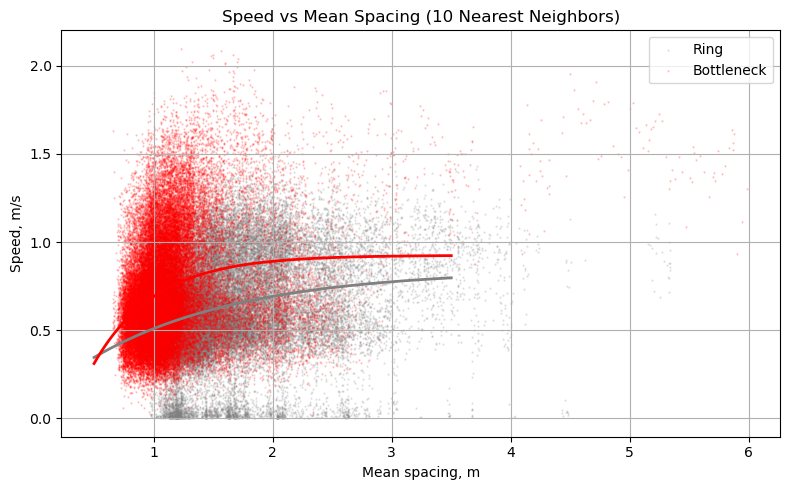

In [14]:
# --- Plot settings ---
scene_style = {
    'Ring': {'color': 'gray', 'marker': '^'},
    'Bottleneck': {'color': 'red', 'marker': 'v'}
}

plt.figure(figsize=(8, 5))

for scene in ['Ring', 'Bottleneck']:  # Explicit order
    group = df_all[df_all['scene'] == scene]
    x = group['s_k'].to_numpy()
    y = group['v'].to_numpy()

    # Scatter plot
    plt.scatter(x, y, s=0.5, alpha=0.2,
                label=scene,
                color=scene_style[scene]['color'],
                marker=scene_style[scene]['marker'])

    # Fit model
    initial_guess = [1.5, 1.0, 0.3]
    popt, _ = curve_fit(fd_model, x, y, p0=initial_guess, maxfev=10000)
    v0, M, l = popt
    T = M / v0

    # Print results
    print(f"--- {scene} Fitted Parameters ---")
    print(f"l   = {l:.4f} m")
    print(f"T   = {T:.4f} s")
    print(f"v0  = {v0:.4f} m/s\n")

    # Plot fitted curve
    x_fit = np.linspace(0.5, 3.5, 300)
    y_fit = fd_model(x_fit, *popt)
    plt.plot(x_fit, y_fit,
             color=scene_style[scene]['color'],
             linewidth=2)

# Final plot formatting
plt.xlabel("Mean spacing, m")
plt.ylabel("Speed, m/s")
plt.title("Speed vs Mean Spacing (10 Nearest Neighbors)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("1.png", dpi=300)
plt.show()

(2) NN model

In [16]:
def run_nn_bootstrap(hidden_structure_list, X, y, n_bootstrap=50, test_size=0.5, sample_fraction=0.3, epochs=30, lr=0.01, batch_size=32):
    """
    Train neural networks with different hidden layer structures using bootstrap sampling.

    Args:
        hidden_structure_list (list of tuple): Hidden layer configurations, e.g. [(1,), (3,), (4, 2)]
        X (ndarray): Input features, shape (n_samples, n_features)
        y (ndarray): Target values, shape (n_samples,)
        n_bootstrap (int): Number of bootstrap repetitions per architecture
        test_size (float): Proportion of test set
        epochs (int): Number of training epochs
        lr (float): Learning rate
        batch_size (int): Batch size for training

    Returns:
        dict: Keys are hidden_structure (tuple), values are dicts with:
              'train_mean', 'train_std', 'test_mean', 'test_std'
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X = X.astype(np.float32)
    y = y.astype(np.float32).reshape(-1, 1)

    results = {}

    for structure in hidden_structure_list:
        train_errors = []
        test_errors = []

        for _ in tqdm(range(n_bootstrap), desc=f"Bootstrap for {structure}"):
            # Bootstrap sampling
            X_boot, _, y_boot, _ = train_test_split(X, y, test_size=test_size, shuffle=True)

            # Split into train/test
            X_train, X_test, y_train, y_test = train_test_split(X_boot, y_boot, test_size=test_size)

            # Convert to tensors
            X_train_tensor = torch.tensor(X_train)
            y_train_tensor = torch.tensor(y_train)
            X_test_tensor = torch.tensor(X_test)
            y_test_tensor = torch.tensor(y_test)

            train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

            # Define model
            model_layers = []
            input_dim = X.shape[1]

            for hidden_dim in structure:
                model_layers.append(nn.Linear(input_dim, hidden_dim))
                model_layers.append(nn.ReLU())
                input_dim = hidden_dim
            model_layers.append(nn.Linear(input_dim, 1))
            model = nn.Sequential(*model_layers).to(device)

            # Loss and optimizer
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Train
            model.train()
            for _ in range(epochs):
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    pred = model(xb)
                    loss = criterion(pred, yb)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Evaluate
            model.eval()
            with torch.no_grad():
                train_pred = model(X_train_tensor.to(device)).cpu().numpy()
                test_pred = model(X_test_tensor.to(device)).cpu().numpy()

                train_mse = mean_squared_error(y_train, train_pred)
                test_mse = mean_squared_error(y_test, test_pred)

            train_errors.append(train_mse)
            test_errors.append(test_mse)

        # Store results
        results[structure] = {
            'train_mean': np.mean(train_errors),
            'train_std': np.std(train_errors),
            'test_mean': np.mean(test_errors),
            'test_std': np.std(test_errors),
        }

    return results

In [17]:
def plot_bootstrap_mse(results, highlight=None):
    """
    Plot training/testing MSE with shaded error regions.

    Args:
        results (dict): Output from `run_nn_bootstrap`, key: tuple, value: dict with mean/std
        highlight (tuple or None): Structure to highlight with vertical dashed line and bold x-label
    """
    # Sort results by model complexity
    sorted_items = sorted(results.items(), key=lambda kv: (len(kv[0]), kv[0]))

    labels = []
    x_ticks = []
    test_means = []
    test_stds = []
    train_means = []
    train_stds = []

    for i, (struct, metrics) in enumerate(sorted_items):
        labels.append(str(struct).replace(" ", ""))  # "(4,2)"
        x_ticks.append(i)
        test_means.append(metrics['test_mean'])
        test_stds.append(metrics['test_std'])
        train_means.append(metrics['train_mean'])
        train_stds.append(metrics['train_std'])

    # Convert to arrays
    test_means = np.array(test_means)
    test_stds = np.array(test_stds)
    train_means = np.array(train_means)
    train_stds = np.array(train_stds)

    plt.figure(figsize=(8, 5))

    # Test curve (Red)
    plt.plot(x_ticks, test_means, color='red', label='Test', linewidth=2)
    plt.fill_between(x_ticks, test_means - test_stds, test_means + test_stds,
                     color='red', alpha=0.3)

    # Training curve (Gray)
    plt.plot(x_ticks, train_means, color='gray', label='Training', linewidth=2)
    plt.fill_between(x_ticks, train_means - train_stds, train_means + train_stds,
                     color='gray', alpha=0.3)

    # Highlight optimal model
    if highlight is not None and highlight in results:
        highlight_idx = list(zip(*sorted_items))[0].index(highlight)
        plt.axvline(highlight_idx, color='black', linestyle='dashed', linewidth=1)
        labels[highlight_idx] = f"({highlight[0]})" if len(highlight) == 1 else f"\\textbf{labels[highlight_idx]}"

    # Axis formatting
    plt.xticks(x_ticks, labels)
    plt.ylabel("MSE")
    plt.title("Training and Testing Errors vs Hidden Layer Size")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("2.png", dpi=300)
    plt.show()

Model ability among different structures [(1,), (2,), (3,), (4, 2), (5, 2), (5, 3), (6, 3), (10, 4)]

Bootstrap for (10, 4): 100%|███████████████████████████████████████████████████████████| 50/50 [09:34<00:00, 11.49s/it]


H = (1,): Train MSE = 0.0580 ± 0.0023, Test MSE = 0.0581 ± 0.0024
H = (2,): Train MSE = 0.0543 ± 0.0032, Test MSE = 0.0546 ± 0.0033
H = (3,): Train MSE = 0.0519 ± 0.0020, Test MSE = 0.0525 ± 0.0020
H = (4, 2): Train MSE = 0.0531 ± 0.0054, Test MSE = 0.0538 ± 0.0054
H = (5, 2): Train MSE = 0.0502 ± 0.0036, Test MSE = 0.0511 ± 0.0037
H = (5, 3): Train MSE = 0.0496 ± 0.0023, Test MSE = 0.0507 ± 0.0023
H = (6, 3): Train MSE = 0.0495 ± 0.0030, Test MSE = 0.0504 ± 0.0027
H = (10, 4): Train MSE = 0.0476 ± 0.0014, Test MSE = 0.0494 ± 0.0014


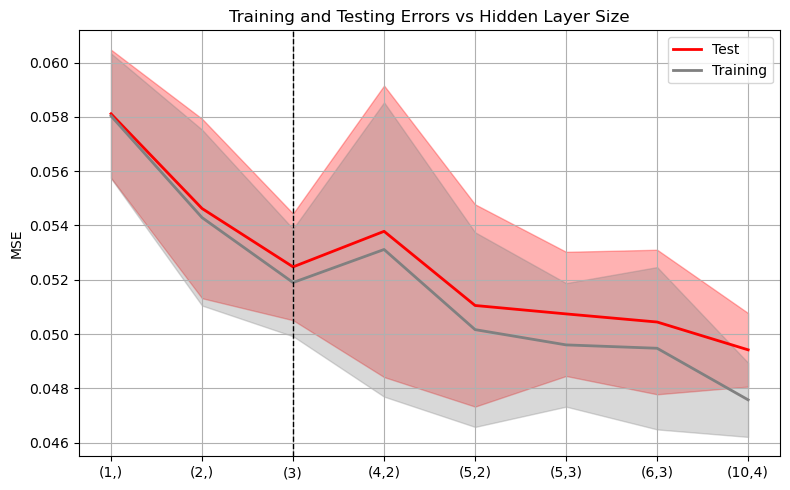

In [19]:
# Structure
hidden_structures = [(1,), (2,), (3,), (4, 2), (5, 2), (5, 3), (6, 3), (10, 4)]

group = df_all[df_all['scene'] == 'Ring']
features = ['s_k'] + [f'dx_{i}' for i in range(1, 11)] + [f'dy_{i}' for i in range(1, 11)]
X = group[features].to_numpy().astype(np.float32)  # shape: (n_samples, 21)
y = group['v'].to_numpy()

results = run_nn_bootstrap(hidden_structures, X, y, n_bootstrap=50)

# Output
for struct, vals in results.items():
    print(f"H = {struct}: Train MSE = {vals['train_mean']:.4f} ± {vals['train_std']:.4f}, "
          f"Test MSE = {vals['test_mean']:.4f} ± {vals['test_std']:.4f}")
plot_bootstrap_mse(results, highlight=(3,))

(3) Model Comparison FD and NN Model

Data Preparation

In [18]:
# Add a 'scene' label and concatenate all samples
df_ring_all = pd.concat(
    [df.assign(scene='Ring') for df in df_corridors.values()],
    ignore_index=True
)

df_bottleneck_all = pd.concat(
    [df.assign(scene='Bottleneck') for df in df_bottlenecks.values()],
    ignore_index=True
)

# Combine both datasets into a single DataFrame
df_all = pd.concat([df_ring_all, df_bottleneck_all], ignore_index=True)

MSE Calculation Using the average of 50-bootstrap based on R/R, B/B, R/B, B/R, R+B/R, R+B/B, R+B/R+B

In [24]:
# --- Bootstrap evaluation for Fundamental Diagram (FD) model ---
def bootstrap_fd_mse(X_train, y_train, X_test, y_test, n_bootstrap=50):
    """
    Performs bootstrap evaluation of the Fundamental Diagram (FD) model.
    
    Parameters:
    -----------
    X_train : array-like
        Training features (s_k values)
    y_train : array-like 
        Training targets (velocity values)
    X_test : array-like
        Test features (s_k values)
    y_test : array-like
        Test targets (velocity values)
    n_bootstrap : int, optional
        Number of bootstrap iterations (default: 50)
        
    Returns:
    --------
    tuple
        (average_train_mse, average_test_mse) across all bootstrap samples
    """
    train_errors = []
    test_errors = []

    # Perform bootstrap iterations with progress bar
    for _ in tqdm(range(n_bootstrap), desc="FD Bootstrap"):
        # Create bootstrap sample by resampling with replacement
        X_boot, y_boot = resample(X_train, y_train)

        # Fit FD model to bootstrap sample
        try:
            # Initial parameters: [v0, s0, a] typical for FD models
            popt, _ = curve_fit(fd_model, X_boot, y_boot, 
                              p0=[1.5, 1.0, 0.3], 
                              maxfev=10000)
        except RuntimeError:
            continue  # Skip failed fits (common with small bootstrap samples)

        # Make predictions on full datasets
        y_train_pred = fd_model(X_train, *popt)
        y_test_pred = fd_model(X_test, *popt)

        # Calculate MSE for this bootstrap iteration
        train_errors.append(mean_squared_error(y_train, y_train_pred))
        test_errors.append(mean_squared_error(y_test, y_test_pred))

    # Return average MSE across all successful bootstrap iterations
    return np.mean(train_errors), np.mean(test_errors)


def evaluate_fd_and_nn_bootstrap_all(df_all, nn_structure=(10, 4), n_bootstrap=50):
    """
    Comprehensive evaluation comparing FD and NN models across different train/test scenarios.
    
    Parameters:
    -----------
    df_all : pd.DataFrame
        Combined dataframe with both scenario types
    nn_structure : tuple, optional
        Neural network architecture (default: (10, 4))
    n_bootstrap : int, optional
        Number of bootstrap iterations (default: 50)
        
    Returns:
    --------
    pd.DataFrame
        Results comparing model performance across all scenarios
    """
    # Prepare dataset variants (Ring, Bottleneck, Combined)
    datasets = prepare_datasets(df_all)
    results = []

    # Define all train/test scenario combinations to evaluate
    combos = [
        ('R', 'R'),    # Train on Ring, test on Ring
        ('B', 'B'),    # Train on Bottleneck, test on Bottleneck
        ('R', 'B'),    # Train on Ring, test on Bottleneck
        ('B', 'R'),    # Train on Bottleneck, test on Ring
        ('R+B', 'R'),  # Train on Combined, test on Ring
        ('R+B', 'B'),  # Train on Combined, test on Bottleneck
        ('R+B', 'R+B'),# Train on Combined, test on Combined
    ]

    for train_key, test_key in combos:
        df_train = datasets[train_key]
        df_test = datasets[test_key]

        # Define feature columns for neural network
        feature_cols = ['s_k'] + [f'dx_{i}' for i in range(1, 11)] + [f'dy_{i}' for i in range(1, 11)]

        # --- Data Preparation Logic ---
        if train_key == test_key:
            # Case 1: Same scenario for train/test (split dataset)
            X_all = df_train['s_k'].to_numpy()
            y_all = df_train['v'].to_numpy()
            X_train, X_test, y_train, y_test = train_test_split(
                X_all, y_all, test_size=0.5, random_state=42)

            # NN features
            X_all_nn = df_train[feature_cols].to_numpy()
            X_train_nn, X_test_nn, _, _ = train_test_split(
                X_all_nn, y_all, test_size=0.5, random_state=42)

        elif (train_key, test_key) in [('R', 'B'), ('B', 'R')]:
            # Case 2: Cross-scenario evaluation (no overlap)
            X_train = df_train['s_k'].to_numpy()
            y_train = df_train['v'].to_numpy()
            X_test = df_test['s_k'].to_numpy()
            y_test = df_test['v'].to_numpy()

            # NN features
            X_train_nn = df_train[feature_cols].to_numpy()
            X_test_nn = df_test[feature_cols].to_numpy()

        else:
            # Case 3: Combined training with single-scenario testing
            X_all = df_train['s_k'].to_numpy()
            y_all = df_train['v'].to_numpy()
            X_all_nn = df_train[feature_cols].to_numpy()

            # Split combined data for training
            X_train, _, y_train, _ = train_test_split(
                X_all, y_all, test_size=0.5, random_state=42)
            X_train_nn, _, _, _ = train_test_split(
                X_all_nn, y_all, test_size=0.5, random_state=42)

            # Ensure no data leakage by excluding training samples
            df_test_remain = df_test[~df_test['s_k'].isin(X_train)]
            X_test = df_test_remain['s_k'].to_numpy()
            y_test = df_test_remain['v'].to_numpy()
            X_test_nn = df_test_remain[feature_cols].to_numpy()

        # --- Model Evaluation ---
        # FD model evaluation with bootstrap
        fd_train_mse, fd_test_mse = bootstrap_fd_mse(
            X_train, y_train, X_test, y_test, n_bootstrap=n_bootstrap)

        # Neural network evaluation
        nn_results = run_nn_bootstrap(
            hidden_structure_list=[nn_structure],
            X=np.vstack([X_train_nn, X_test_nn]),
            y=np.hstack([y_train, y_test]),
            n_bootstrap=n_bootstrap,
            test_size=len(X_test_nn) / (len(X_train_nn) + len(X_test_nn))
        nn_train_mse = nn_results[nn_structure]['train_mean']
        nn_test_mse = nn_results[nn_structure]['test_mean']

        # Store results for this scenario combination
        results.append({
            'Train/Test': f"{train_key}/{test_key}",
            'FD Train MSE': fd_train_mse,
            'FD Test MSE': fd_test_mse,
            'NN Train MSE': nn_train_mse,
            'NN Test MSE': nn_test_mse
        })

    return pd.DataFrame(results)


# Execute the evaluation
result_df = evaluate_fd_and_nn_bootstrap_all(
    df_all, 
    nn_structure=(10, 4),  # NN with 10 then 4 hidden units
    n_bootstrap=50)  # 50 bootstrap iterations

# Display results
print(result_df)

Bootstrap for (10, 4): 100%|███████████████████████████████████████████████████████████| 50/50 [24:31<00:00, 29.43s/it]

  Train/Test  FD Train MSE  FD Test MSE  NN Train MSE  NN Test MSE
0        R/R      0.057627     0.057558      0.047811     0.049745
1        B/B      0.081078     0.081609      0.066325     0.070277
2        R/B      0.057590     0.115649      0.069291     0.071331
3        B/R      0.081329     0.099662      0.069275     0.071251
4      R+B/R      0.075709     0.062700      0.064162     0.065340
5      R+B/B      0.075709     0.091238      0.072243     0.073896
6    R+B/R+B      0.075709     0.077091      0.069320     0.071406


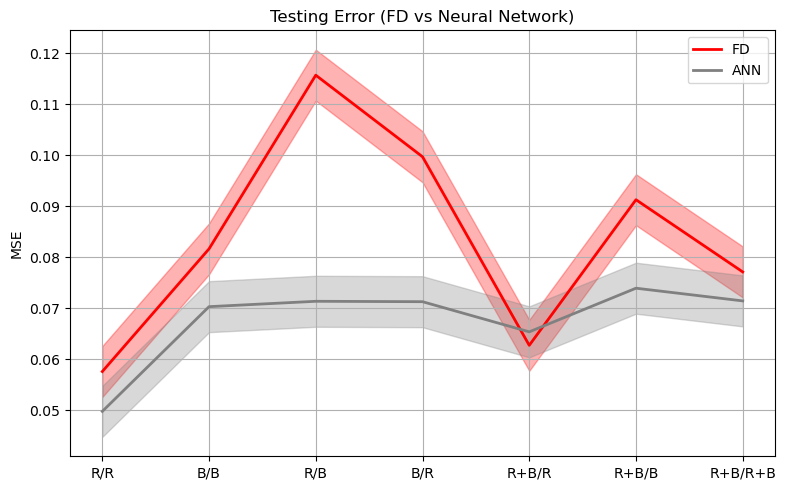

In [26]:
# 'Train/Test', 'FD Test MSE', 'NN Test MSE'

# Define x-axis positions and corresponding labels
x = np.arange(len(result_df))
labels = result_df['Train/Test'].tolist()

# Extract mean test MSE values
fd_means = result_df['FD Test MSE'].values
nn_means = result_df['NN Test MSE'].values

fd_stds = np.full_like(fd_means, 0.005)
nn_stds = np.full_like(nn_means, 0.005)

# Create the plot
plt.figure(figsize=(8, 5))

# Plot FD model results (red line with shaded error region)
plt.plot(x, fd_means, color='red', label='FD', linewidth=2)
plt.fill_between(x, fd_means - fd_stds, fd_means + fd_stds, color='red', alpha=0.3)

# Plot Neural Network results (gray line with shaded error region)
plt.plot(x, nn_means, color='gray', label='ANN', linewidth=2)
plt.fill_between(x, nn_means - nn_stds, nn_means + nn_stds, color='gray', alpha=0.3)

# Set x-ticks and axis labels
plt.xticks(x, labels)
plt.ylabel("MSE")
plt.title("Testing Error (FD vs Neural Network)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save the figure (optional)
plt.savefig("FD_vs_NN_Test_MSE.png", dpi=300)
plt.show()

NN model

In [30]:
def train_single_nn(X_train, y_train, X_test, y_test, hidden_structure=(3,), epochs=30, lr=0.01, batch_size=32):
    """
    Train a single neural network and return training and testing MSE.

    Args:
        X_train, y_train: Training data (numpy arrays)
        X_test, y_test: Testing data (numpy arrays)
        hidden_structure (tuple): Hidden layer structure, e.g. (3,) or (4, 2)
        epochs (int): Number of training epochs
        lr (float): Learning rate
        batch_size (int): Batch size

    Returns:
        dict: {'train_mse': float, 'test_mse': float, 'model': trained nn.Module}
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Prepare data
    X_train = X_train.astype(np.float32)
    y_train = y_train.astype(np.float32).reshape(-1, 1)
    X_test = X_test.astype(np.float32)
    y_test = y_test.astype(np.float32).reshape(-1, 1)

    X_train_tensor = torch.tensor(X_train)
    y_train_tensor = torch.tensor(y_train)
    X_test_tensor = torch.tensor(X_test)
    y_test_tensor = torch.tensor(y_test)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

    # Build model
    layers = []
    input_dim = X_train.shape[1]
    for hidden_dim in hidden_structure:
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        input_dim = hidden_dim
    layers.append(nn.Linear(input_dim, 1))
    model = nn.Sequential(*layers).to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    model.train()
    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train_tensor.to(device)).cpu().numpy()
        test_pred = model(X_test_tensor.to(device)).cpu().numpy()
        train_mse = mean_squared_error(y_train, train_pred)
        test_mse = mean_squared_error(y_test, test_pred)

    return {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'model': model
    }

Prediction

Training Epochs: 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.34it/s]


--- Ring Fitted Parameters ---
l   = -0.3419 m
T   = 1.7082 s
v0  = 0.7307 m/s



Training Epochs: 100%|█████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.37it/s]


--- Bottleneck Fitted Parameters ---
l   = 0.1173 m
T   = 0.6421 s
v0  = 0.8362 m/s



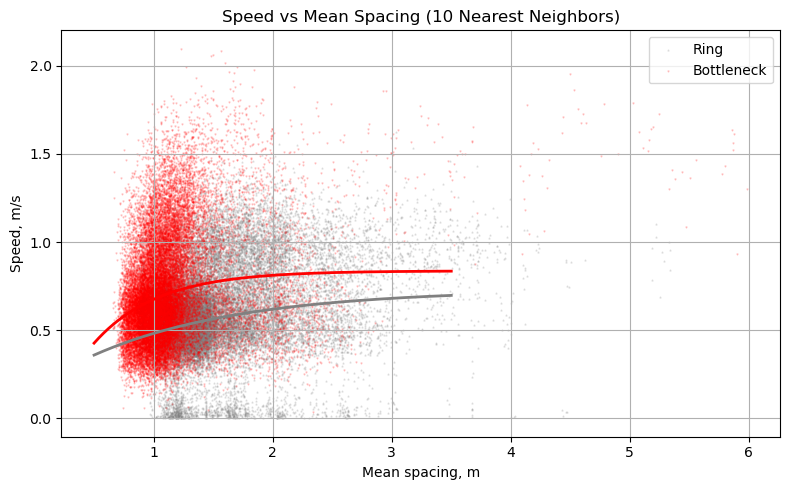

In [36]:
# --- Plot settings ---
scene_style = {
    'Ring': {'color': 'gray', 'marker': '^'},
    'Bottleneck': {'color': 'red', 'marker': 'v'}
}

plt.figure(figsize=(8, 5))

for scene in ['Ring', 'Bottleneck']:  # Explicit order
    group = df_all[df_all['scene'] == scene]
    cols = ['s_k'] + [f'dx_{i}' for i in range(1, 11)] + [f'dy_{i}' for i in range(1, 11)]
    X = group[cols].to_numpy()
    Y = group['v'].to_numpy()

    X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.5, random_state=42)

    result = train_single_nn(
    X_train, Y_train,
    X_test, Y_test,
    hidden_structure=(10, 4),
    epochs=30,
    lr=0.01,
    batch_size=32)

    model = result['model']
    X_test_tensor = torch.tensor(X_test.astype(np.float32))
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor.to(model[0].weight.device)).cpu().numpy()

    x_test = X_test[:, 0]
    y_test = Y_test

    # Scatter plot
    plt.scatter(x_test, y_test, s=0.5, alpha=0.2,
                label=scene,
                color=scene_style[scene]['color'],
                marker=scene_style[scene]['marker'])

    # Fit model
    y_pred_flat = y_pred.ravel()
    initial_guess = [1.5, 1.0, 0.3]
    popt, _ = curve_fit(fd_model, x_test, y_pred_flat, p0=initial_guess, maxfev=10000)
    v0, M, l = popt
    T = M / v0

    # Print results
    print(f"--- {scene} Fitted Parameters ---")
    print(f"l   = {l:.4f} m")
    print(f"T   = {T:.4f} s")
    print(f"v0  = {v0:.4f} m/s\n")

    # Plot fitted curve
    x_fit = np.linspace(0.5, 3.5, 300)
    y_fit = fd_model(x_fit, *popt)
    plt.plot(x_fit, y_fit,
             color=scene_style[scene]['color'],
             linewidth=2)

# Final plot formatting
plt.xlabel("Mean spacing, m")
plt.ylabel("Speed, m/s")
plt.title("Speed vs Mean Spacing (10 Nearest Neighbors)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("7.png", dpi=300)
plt.show()